In [36]:
import cv2
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Point, MultiLineString

def threshold_by_contour_count(contour_count):
    if contour_count <= 50:
        return 500
    elif contour_count <= 100:
        return 1000
    elif contour_count <= 500:
        return 5000
    elif contour_count <= 1500:
        return 7500
    else:
        return 10000

def detect_plant_rows_with_rectangles(image_path, threshhold_default = None):
    # load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # change color from rgb to hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # define green range (may need to be adjusted)
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # morphological filter (noise removal)
    kernel = np.ones((5,5), np.uint8)
    mask_clean = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

    # find contoues
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Anzahl gefundener Konturen: {len(contours)}")

    if threshhold_default is None:
        # dynamic threshold
        threshhold = threshold_by_contour_count(len(contours))
    else:
        threshhold = threshhold_default

    # copy image to show recognized plants with circles
    img_rects = img_rgb.copy()

    # array of centers of circles
    circles = []

    for cnt in contours:
        area = cv2.contourArea(cnt)

        if area > threshhold:  
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            center = (int(x), int(y))
            radius = int(radius)
            circles.append((center, radius))
            print(f"Kreis Werte: Mittelpunkt: {center}, Radius: {radius}")
            cv2.circle(img_rects, center, radius, (0, 0, 255), 5)

    # Ergebnisse anzeigen
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Grün Maske")
    plt.imshow(mask_clean, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Erkannte Pflanzen")
    plt.imshow(cv2.cvtColor(img_rects, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

    return circles

Anzahl gefundener Konturen: 1125
Kreis Werte: Mittelpunkt: (1509, 3673), Radius: 148
Kreis Werte: Mittelpunkt: (1393, 2861), Radius: 234
Kreis Werte: Mittelpunkt: (1384, 1487), Radius: 124
Kreis Werte: Mittelpunkt: (1503, 862), Radius: 151
Kreis Werte: Mittelpunkt: (1474, 558), Radius: 225
Kreis Werte: Mittelpunkt: (1456, 182), Radius: 203


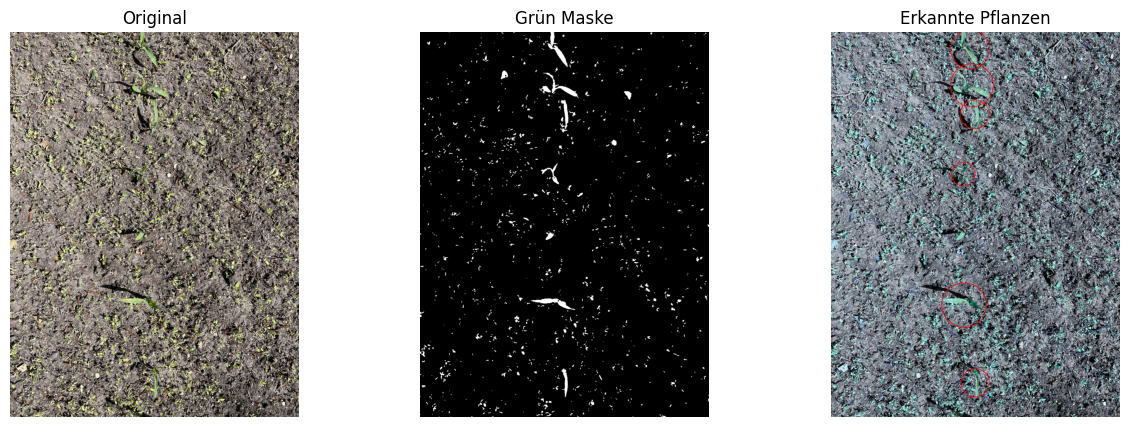

circles: [((1509, 3673), 148), ((1393, 2861), 234), ((1384, 1487), 124), ((1503, 862), 151), ((1474, 558), 225), ((1456, 182), 203)]
Anzahl gefundener Konturen: 1125
Kreis Werte: Mittelpunkt: (2545, 4027), Radius: 25
Kreis Werte: Mittelpunkt: (1653, 4024), Radius: 9
Kreis Werte: Mittelpunkt: (1237, 4010), Radius: 21
Kreis Werte: Mittelpunkt: (1278, 4006), Radius: 10
Kreis Werte: Mittelpunkt: (1350, 4012), Radius: 26
Kreis Werte: Mittelpunkt: (1585, 4004), Radius: 15
Kreis Werte: Mittelpunkt: (1711, 3995), Radius: 10
Kreis Werte: Mittelpunkt: (669, 3993), Radius: 13
Kreis Werte: Mittelpunkt: (727, 3988), Radius: 16
Kreis Werte: Mittelpunkt: (1329, 3990), Radius: 15
Kreis Werte: Mittelpunkt: (847, 3986), Radius: 16
Kreis Werte: Mittelpunkt: (1391, 3977), Radius: 16
Kreis Werte: Mittelpunkt: (304, 3979), Radius: 12
Kreis Werte: Mittelpunkt: (1277, 3977), Radius: 13
Kreis Werte: Mittelpunkt: (665, 3939), Radius: 16
Kreis Werte: Mittelpunkt: (806, 3950), Radius: 27
Kreis Werte: Mittelpunkt:

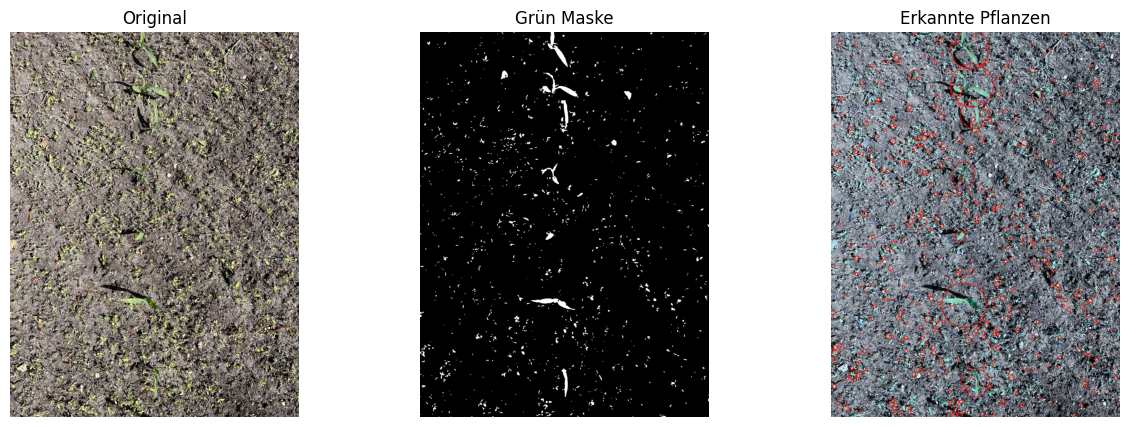

Centers of intersecting circles: [(1509, 3673), (1393, 2861), (1384, 1487), (1503, 862), (1474, 558), (1456, 182), (2545, 4027), (1653, 4024), (1237, 4010), (1278, 4006), (1350, 4012), (1585, 4004), (1711, 3995), (669, 3993), (727, 3988), (1329, 3990), (847, 3986), (1391, 3977), (304, 3979), (1277, 3977), (665, 3939), (806, 3950), (157, 3942), (1999, 3915), (2621, 3914), (1315, 3926), (2320, 3902), (1245, 3905), (154, 3898), (678, 3906), (1247, 3888), (2782, 3886), (627, 3904), (1774, 3892), (73, 3887), (1361, 3872), (1326, 3875), (1805, 3878), (2181, 3856), (647, 3861), (3017, 3853), (2210, 3843), (1281, 3855), (103, 3823), (1940, 3787), (2097, 3762), (1244, 3767), (2748, 3755), (1626, 3747), (1397, 3731), (1432, 3734), (1439, 3712), (1652, 3714), (36, 3709), (2672, 3704), (2645, 3679), (2674, 3653), (250, 3646), (1448, 3627), (171, 3627), (1130, 3624), (2982, 3619), (1888, 3619), (297, 3591), (877, 3581), (1028, 3578), (229, 3595), (1210, 3564), (1852, 3559), (928, 3548), (290, 3549)

In [39]:
# find all circles crossing the lines -> these areas need to be blocked as they contain crops
# any remaining plants are weeds

img_path = '2_dataset/images/corn/IMG_4043.png'

# parameter for Hough-Transformation
minLineLength = 100
threshholdHoughLines = 5
maxLineGap = 2500

# parameter for filtering
minAngle = 85
maxAngle = 95
lineArea = 300

# find green contours and the center of their surrounding circle
circles = detect_plant_rows_with_rectangles(img_path)
print(f"circles: {circles}")


imgOutput = cv2.imread(img_path)
height, width = imgOutput.shape[:2]
x_center = width // 2

# create empty image
imgHoughTransformation = np.zeros((height, width), dtype=np.uint8)

# add center of circles 
for circle in circles:
    cv2.circle(imgHoughTransformation, circle[0], radius=10, color=255, thickness=-1)
    cv2.circle(imgOutput, circle[0], radius=circle[1], color=(0, 0, 255), thickness=5)


# use Hough-Line-Transformation
lines = cv2.HoughLinesP(imgHoughTransformation, rho=1, theta=np.pi/180, threshold=threshholdHoughLines, minLineLength=minLineLength, maxLineGap=maxLineGap)

circles += detect_plant_rows_with_rectangles(img_path, 100)

# calculate boundary of circles
# buffer creates a circular polygon approximation around the center point using given radius
circlesWithBoundary = [(Point(center), Point(center).buffer(radius).boundary) for center, radius in circles]


weedCircles = []
plantCircles = []

# visualize the lines of the crops
if lines is not None:
    out = np.empty((len(lines), len(circles)), dtype=bool)

    for j, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        dx = x2 - x1
        dy = y2 - y1
        theta = np.arctan2(dy, dx)  # angle of lines in radians

        angle_deg = abs(np.degrees(theta))  # only positive angles

        # norm angles to [0°, 180°]
        if angle_deg > 180:
            angle_deg -= 180

        # only approx. vertical lines
        if minAngle <= angle_deg <= maxAngle:
            x_mean = (x1 + x2) / 2

            # only lines in the center of the image are relevant
            if abs(x_mean - x_center) <= lineArea:
                cv2.line(imgOutput, (x1, y1), (x2, y2), (0, 0, 255), 10)

                # convert to LineString for calculating intersections
                lsLine = LineString([(x1, y1), (x2, y2)])

                for i, (center, boundary) in enumerate(circlesWithBoundary):
                    out[j, i] = lsLine.intersects(boundary)

    # get coordinates of intersecting and non-intersecting circles
    circleIntersections = out.any(axis=0)

    withIntersections = [circles[i][0] for i in np.where(circleIntersections)[0]]
    noIntersections = [circles[i][0] for i in np.where(~circleIntersections)[0]]

    print("Centers of intersecting circles:", withIntersections)
    print("Centers of non-intersecting circles:", noIntersections)

    # downscale image
    imgOutput = cv2.resize(imgOutput, None, fx = 0.15, fy = 0.15)
    cv2.imshow('Linien', imgOutput)
    cv2.waitKey(0)







 